In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
import os
import sys
sys.path.insert(0, work)
from illustris_sim import TNGSim
import corrfunc_ls
import tools

### redshift uncertainties

https://github.com/SPHEREx/Public-products

Relationship between redshift and physical distance:

$$
\sigma_z = \frac{dv}{c} = \frac{dz}{1+z} = dx\, \frac{H(x)}{c} \left[ \frac{1}{1+z} \right]
$$

$$
dx = \sigma_z ( 1+z ) \frac{c}{H(x)}
$$

Importantly, this formula returns the distance $dx$ in $\mathrm{Mpc}$, whereas TNG gives their values in $\mathrm{Mpc}/h$.

So we need to convert $dx$ to $\mathrm{Mpc}/h$:

$$
H_0 = 100\,h\,\mathrm{km\,s}^{-1}\mathrm{Mpc}^{-1}
$$
$$
h = \frac{H_0}{100}\mathrm{Mpc\,km}^{-1}\mathrm{s}
$$

In [4]:
h = cosmo.H(0.) / 100 * u.Mpc / u.km * u.s
h

<Quantity 0.6774>

In [5]:
def perh():
    return (cosmo.H(0.) / 100 * u.Mpc / u.km * u.s) / cu.littleh

In [6]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / cosmo.H(z) * perh()

To simulate redshift uncertainty in TNG, take the given tracer positions and move each along the LOS based on a Gaussian draw with $dx$:

In [7]:
def Gaussian_draw(dx, size=None):
    if isinstance(dx, u.Quantity):
        return np.random.normal(loc=0.0, scale=dx.value, size=size) * dx.unit
    else:
        return np.random.normal(loc=0.0, scale=dx, size=size)

Load in a TNG simulation:

In [8]:
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)

In [9]:
# check the numbers...
cosmo.H(redshift)

<Quantity 89.20061823 km / (Mpc s)>

In [10]:
c.c.to(u.km/u.s) / cosmo.H(1.)

<Quantity 2488.21100193 Mpc>

In [11]:
c.c.to(u.km/u.s) / cosmo.H(1.) * perh()

<Quantity 1685.51413271 Mpc / littleh>

Length of the box:

In [12]:
sim.boxsize

<Quantity 205. Mpc / littleh>

Take a $\sigma_z$ from the SPHEREx public product repo (assuming worst redshift uncertainty per bin), load in the corresponding galaxies, and perturb each one along the LOS (take the LOS to be along the $z$ axis):

In [14]:
sigma_z = 0.01
gal_pos = sim.subhalo_pos()[sim.gal_idx('ELG', 'SPHEREx', sigma_z=sigma_z, verbose=True)]

ELG number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


In [15]:
# center the positions
gal_pos -= np.mean(gal_pos)
print(gal_pos.shape, gal_pos.unit)
gal_pos

(7224, 3) Mpc / littleh


<Quantity [[  -1.9983292,  -79.88356  ,   35.070747 ],
           [  82.08079  ,    3.4645157,   95.21343  ],
           [  24.95523  ,  -28.623192 , -101.20188  ],
           ...,
           [ -31.388618 ,  -77.65042  ,  -56.77799  ],
           [ -16.005592 ,   38.86445  ,   86.35949  ],
           [ -94.616325 ,  -98.66477  ,   41.75875  ]] Mpc / littleh>

In [16]:
dx = get_dx(redshift, sigma_z)
dx

<Quantity 34.14988849 Mpc / littleh>

In [17]:
# what fraction of the box is this?
dx / sim.boxsize

<Quantity 0.16658482>

In [18]:
gal_pos_perturbed = np.copy(gal_pos)
gal_pos_perturbed[:,2] += Gaussian_draw(dx, size=len(gal_pos))

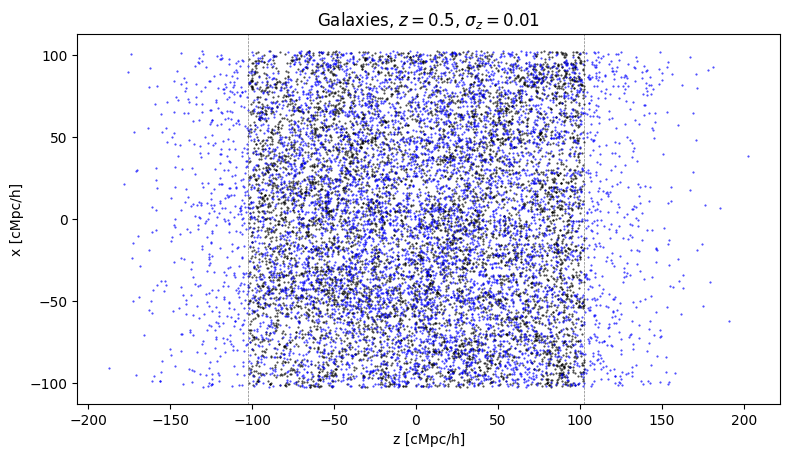

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

kwargs = dict(ls='None', marker='.', ms=1, alpha=0.8)
ax.plot(gal_pos[:,2].value, gal_pos[:,0].value, color='k', **kwargs)
ax.plot(gal_pos_perturbed[:,2].value, gal_pos_perturbed[:,0].value, color='b', **kwargs)
ax.axvline(min(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
ax.axvline(max(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('x [cMpc/h]')
ax.set_title(f'Galaxies, $z={redshift}$, $\sigma_z={sigma_z}$')
fig.tight_layout()

### all redshift uncertainty bins

In [20]:
spherex_sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]

ELG number density for SPHEREx at z=0.5: 5.01e-04 (h/Mpc)^3 
target number of subhalos: 4316
ELG number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
ELG number density for SPHEREx at z=0.5: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186
ELG number density for SPHEREx at z=0.5: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
ELG number density for SPHEREx at z=0.5: 3.27e-03 (h/Mpc)^3 
target number of subhalos: 28171


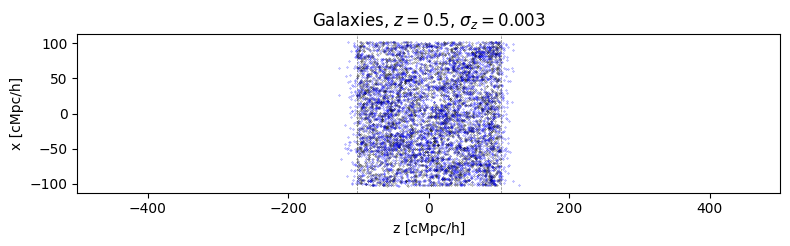

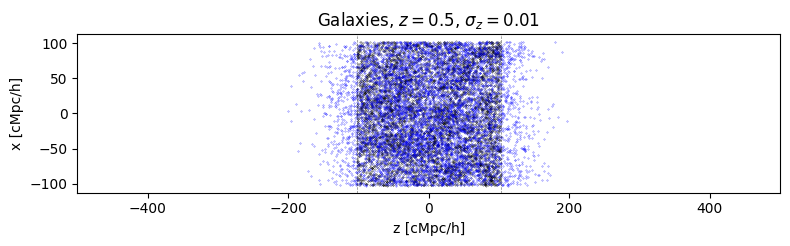

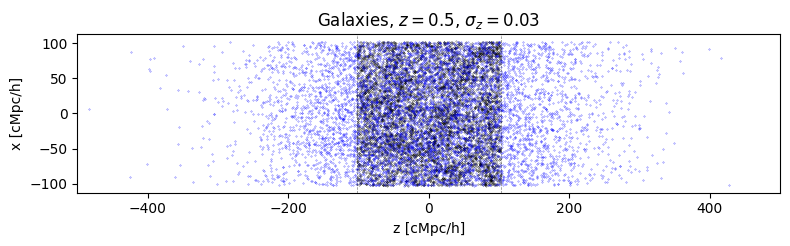

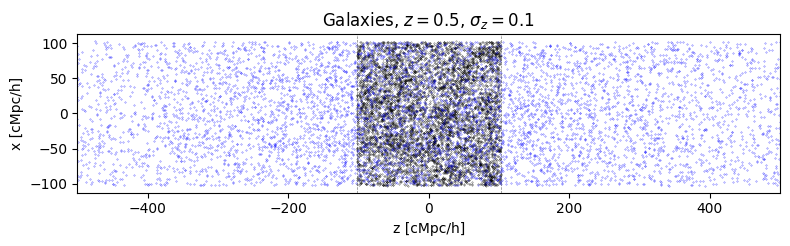

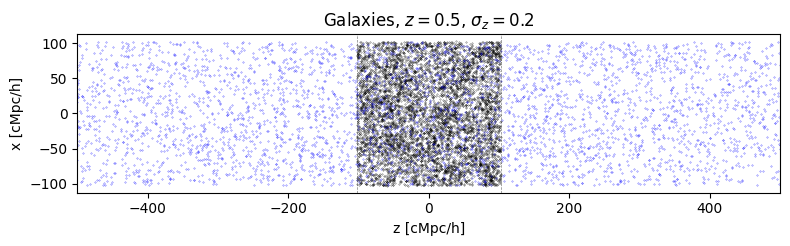

In [22]:
dxs = np.zeros_like(spherex_sigma_zs)
frac_outs = np.zeros_like(dxs)
for i, sigma_z in enumerate(spherex_sigma_zs):
    gal_pos = sim.subhalo_pos()[sim.gal_idx('ELG', 'SPHEREx', sigma_z=sigma_z, verbose=True)]
    gal_pos -= sim.boxsize / 2
    dx = get_dx(redshift, sigma_z)
    gal_pos_perturbed = np.copy(gal_pos)
    gal_pos_perturbed[:,2] += Gaussian_draw(dx, size=len(gal_pos))
    
    z = gal_pos[:,2]
    z_err = gal_pos_perturbed[:,2]
    
    dxs[i] = dx.value
    frac_outs[i] = sum([a or b for a, b in zip((z_err < min(z)), (z_err > max(z)))]) / len(gal_pos)
    
    fig, ax = plt.subplots(figsize=(8,5))
    kwargs = dict(ls='None', marker='.', ms=0.5, alpha=0.8)
    ax.plot(gal_pos[:,2].value, gal_pos[:,0].value, color='k', **kwargs)
    ax.plot(gal_pos_perturbed[:,2].value, gal_pos_perturbed[:,0].value, color='b', **kwargs)
    ax.axvline(min(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
    ax.axvline(max(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
    ax.set_xlim(-500,500)
    ax.set_aspect('equal')
    ax.set_xlabel('z [cMpc/h]')
    ax.set_ylabel('x [cMpc/h]')
    ax.set_title(f'Galaxies, $z={redshift}$, $\sigma_z={sigma_z}$')
    fig.tight_layout()

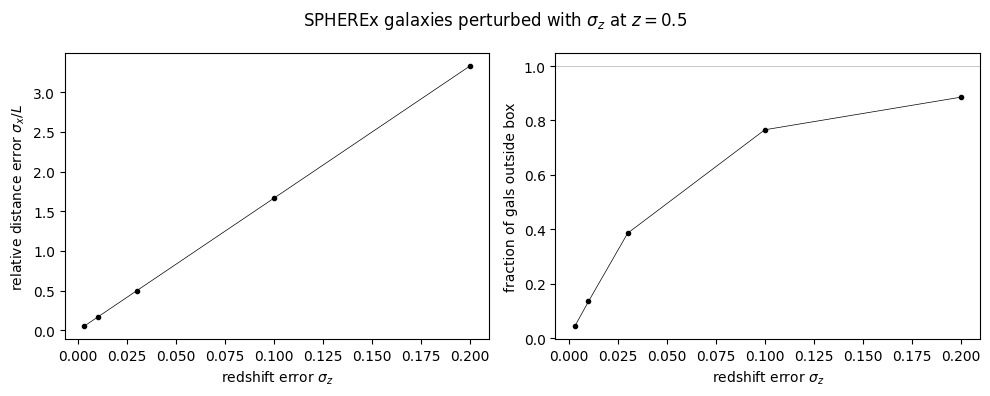

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(spherex_sigma_zs, dxs/sim.boxsize.value, 'k.-', lw=0.5, ms=6)
axs[1].plot(spherex_sigma_zs, frac_outs, 'k.-', lw=0.5, ms=6)
axs[1].axhline(1., color='k', alpha=0.3, lw=0.5)
axs[0].set_ylabel('relative distance error $\sigma_x/L$') #' ($h^{-1}$Mpc)')
axs[1].set_ylabel('fraction of gals outside box')
for ax in axs:
    ax.set_xlabel('redshift error $\sigma_z$')
fig.suptitle(f'SPHEREx galaxies perturbed with $\sigma_z$ at $z=${redshift:.1f}')
fig.tight_layout()

In [27]:
redshifts = [0.1, 0.5, 1., 1.5, 2.]

dxs = np.zeros((len(redshifts), len(spherex_sigma_zs)))
frac_outs = np.zeros_like(dxs)

for i, redshift in enumerate(redshifts):
    sim = TNGSim('TNG300-3', redshift=redshift)
    for j, sigma_z in enumerate(spherex_sigma_zs):
        gal_pos = sim.subhalo_pos()[sim.gal_idx('ELG', 'SPHEREx', sigma_z=sigma_z, verbose=True)]
        gal_pos -= sim.boxsize / 2
        dx = get_dx(redshift, sigma_z)
        gal_pos_perturbed = np.copy(gal_pos)
        gal_pos_perturbed[:,2] += Gaussian_draw(dx, size=len(gal_pos))

        z = gal_pos[:,2]
        z_err = gal_pos_perturbed[:,2]

        dxs[i,j] = dx.value
        frac_outs[i,j] = sum([a or b for a, b in zip((z_err < min(z)), (z_err > max(z)))]) / len(gal_pos)

ELG number density for SPHEREx at z=0.1: 9.97e-03 (h/Mpc)^3 
target number of subhalos: 85892
ELG number density for SPHEREx at z=0.1: 1.23e-02 (h/Mpc)^3 
target number of subhalos: 105966
ELG number density for SPHEREx at z=0.1: 1.34e-02 (h/Mpc)^3 
target number of subhalos: 115442
ELG number density for SPHEREx at z=0.1: 2.29e-02 (h/Mpc)^3 
target number of subhalos: 197286
ELG number density for SPHEREx at z=0.1: 1.49e-02 (h/Mpc)^3 
target number of subhalos: 128365
ELG number density for SPHEREx at z=0.5: 5.01e-04 (h/Mpc)^3 
target number of subhalos: 4316
ELG number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
ELG number density for SPHEREx at z=0.5: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186
ELG number density for SPHEREx at z=0.5: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
ELG number density for SPHEREx at z=0.5: 3.27e-03 (h/Mpc)^3 
target number of subhalos: 28171
ELG number density for SPHEREx at z=1.0: 1.64e-05 (h/Mpc)

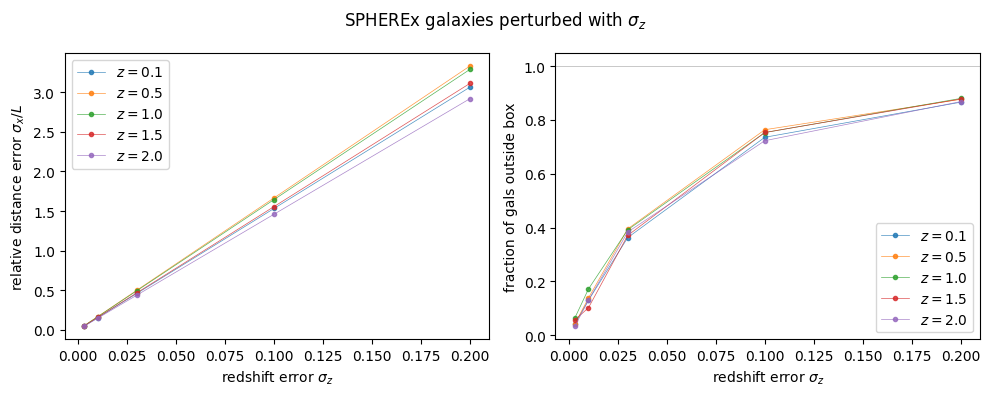

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

for i, redshift in enumerate(redshifts):
    kwargs = dict(marker='.', ls='-', lw=0.5, ms=6, alpha=0.8, label=f'$z=${redshift:.1f}')
    axs[0].plot(spherex_sigma_zs, dxs[i]/sim.boxsize.value, **kwargs)
    axs[1].plot(spherex_sigma_zs, frac_outs[i], **kwargs)
axs[1].axhline(1., color='k', alpha=0.3, lw=0.5)
axs[0].set_ylabel('relative distance error $\sigma_x/L$') #' ($h^{-1}$Mpc)')
axs[1].set_ylabel('fraction of gals outside box')
for ax in axs:
    ax.set_xlabel('redshift error $\sigma_z$')
    ax.legend()
fig.suptitle(f'SPHEREx galaxies perturbed with $\sigma_z$')
fig.tight_layout()

#### Gal x DM